# 2 - Ingeniería de Características

- Este notebook hace la ingeniería de variables (feature engineering) sin modelados. Tiene por objetivo dejar los datos listos para: análisis bivariado más avanzado, hipótesis testeables y modelado posterior.
- Se guardan artefactos finales: `processed` CSV's y figuras. Todas las celdas contienen salidas en consola y producen las figuras dentro del Notebook aparte de guardarlas en físico.

## 1. Preparación (imports y creación de carpetas)

In [35]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_theme(style="whitegrid")

# Definir rutas
BASE = Path('..')
RAW = BASE / 'data' / 'raw_converted'
PROCESSED = BASE / 'data' / 'processed'
FIGURES_RAW = BASE / 'reports' / 'figures' / 'raw'
FIGURES_PROC = BASE / 'reports' / 'figures' / 'processed'

# Crear directorios si no existen
for p in [PROCESSED, FIGURES_PROC]:
    p.mkdir(parents=True, exist_ok=True)

print('Rutas preparadas.')
print(f'RAW: {RAW}')
print(f'PROCESSED: {PROCESSED}')
print(f'FIGURES_PROC: {FIGURES_PROC}')

Rutas preparadas.
RAW: ..\data\raw_converted
PROCESSED: ..\data\processed
FIGURES_PROC: ..\reports\figures\processed


## 2. Carga de Datasets (mantener nombres tal como en el Notebook 01)

In [36]:
# Carga
datasets = {}
for file in os.listdir(RAW):
    if file.endswith('.csv'):
        key = file.replace('.csv', '')
        datasets[key] = pd.read_csv(RAW / file)
        print(f"Cargado {file} -> shape {datasets[key].shape}")

# Asignar datasets a variables para facilitar kectura
clientes = datasets.get('clientes').copy()
ventas = datasets.get('ventas').copy()
inventario = datasets.get('inventario').copy()
marketing = datasets.get('marketing').copy()
web_data = datasets.get('web_data').copy()

print('\nResumen de filas;')
print(f'Clientes: {clientes.shape}')
print(f'Ventas: {ventas.shape}')
print(f'Inventario: {inventario.shape}')
print(f'Marketing: {marketing.shape}')
print(f'Web Data: {web_data.shape}')

Cargado clientes.csv -> shape (300, 7)
Cargado inventario.csv -> shape (8, 6)
Cargado marketing.csv -> shape (150, 9)
Cargado ventas.csv -> shape (1000, 9)
Cargado web_data.csv -> shape (800, 9)

Resumen de filas;
Clientes: (300, 7)
Ventas: (1000, 9)
Inventario: (8, 6)
Marketing: (150, 9)
Web Data: (800, 9)


## 3. Normalizaciones Iniciales y Limpieza Mínima

Recordatorio: en el Notebook anterior se conviertieron fechas, pero acá se refuerzan tipos, nombres de columnas (sinónimos), y se crean columnas clave que se usan repetidas veces.

In [37]:
# ============================================
# 3. Limpieza ligera + Normalización de nombres
# ============================================

def normalize_columns(df, mapping):
    """
    Renombra columnas según un diccionario y estandariza snake_case.
    """
    df = df.rename(columns=mapping)
    
    # Conversión a snake_case
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("(", "", regex=False)
        .str.replace(")", "", regex=False)
        .str.replace("%", "pct", regex=False)
    )
    return df

# ---- Diccionarios de renombre ---- #

rename_ventas = {
    "Línea de Producto": "linea_de_producto",
    "Unidades Vendidas": "unidades_vendidas",
    "Precio Unitario": "precio_unitario",
    "Descuento (%)": "descuento_pct",
    "Total Ingresos": "total_ingresos"
}

rename_clientes = {
    "Cliente ID": "cliente_id",
    "Fecha Encuesta": "fecha_encuesta",
    "Línea Usada": "linea_usada",
    "Satisfacción (1-5)": "satisfaccion"
}

rename_marketing = {
    "Línea Asociada": "linea_asociada",
    "Inversión USD": "inversion_usd",
    "CTR (%)": "ctr_pct"
}

rename_web = {
    "Página Visitada": "pagina_visitada",
    "Tiempo en Página (s)": "tiempo_en_pagina_s",
    "Clic en Producto": "clic_en_producto",
    "Añadir al Carrito": "anadir_al_carrito",
    "Compra Completada": "compra_completada"
}

# ---- Aplicar renombre y normalización ---- #
ventas = normalize_columns(ventas, rename_ventas)
clientes = normalize_columns(clientes, rename_clientes)
inventario = normalize_columns(inventario, {})     # ya está bien
marketing = normalize_columns(marketing, rename_marketing)
web_data = normalize_columns(web_data, rename_web)

print("Columnas estandarizadas correctamente.\n")

# Mostrar las columnas finales para confirmación
for name, df in zip(
    ["Ventas", "Clientes", "Inventario", "Marketing", "Web Data"],
    [ventas, clientes, inventario, marketing, web_data]
):
    print(f"{name}: {list(df.columns)}\n")

# ---- Normalización de etiquetas de líneas ---- #

def normalize_lineas(series):
    return (
        series.str.strip()
        .str.lower()
        .str.replace("línea", "linea")
        .str.replace(" ", "_")
    )

ventas["linea_de_producto"] = normalize_lineas(ventas["linea_de_producto"])
clientes["linea_usada"] = normalize_lineas(clientes["linea_usada"])
marketing["linea_asociada"] = normalize_lineas(marketing["linea_asociada"])

# Web_data tiene formatos tipo "Línea Joven - Serum"
web_data["linea"] = (
    web_data["pagina_visitada"]
    .str.extract(r"(Línea\s+\w+)", expand=False)
    .str.strip()
    .str.replace("Línea", "linea")
    .str.replace(" ", "_")
    .str.lower()
)

print("\nNormalización de líneas completada.")


Columnas estandarizadas correctamente.

Ventas: ['fecha', 'región', 'canal', 'linea_de_producto', 'sku', 'unidades_vendidas', 'precio_unitario', 'descuento_pct', 'total_ingresos']

Clientes: ['cliente_id', 'edad', 'región', 'fecha_encuesta', 'linea_usada', 'satisfaccion', 'comentarios']

Inventario: ['sku', 'nombre_producto', 'stock_actual', 'stock_ideal', 'devoluciones_último_mes', 'motivo_devolución']

Marketing: ['fecha', 'canal', 'campaña', 'linea_asociada', 'inversion_usd', 'cpm', 'cpc', 'ctr_pct', 'conversiones']

Web Data: ['fecha', 'región', 'campaña', 'canal_origen', 'pagina_visitada', 'tiempo_en_pagina_s', 'clic_en_producto', 'anadir_al_carrito', 'compra_completada']


Normalización de líneas completada.


## 4. Feature Engineering Básico

Se crean nuevas columnas útiles para análisis y modelado.
Este conjunto es 100% seguro porque **no requiere de suposiciones**, solamente transforma variables existentes.

Incluye:
- Años / meses / días a partir de las fechas
- Margen de descuentos de ventas.
- Valor total real luego del descuento.
- Conversiones derivadas en `web_data`.
- Indicadores binarios para "Línea Joven" para cada dataset-

In [38]:
# 4. Feature Engineering Básico

print("Iniciando creación de variables derivadas...\n")

# Utilidad para asegurar datetime
def ensure_datetime(df, col):
    col_norm = col.lower().replace("á","a").replace("í","i").replace("é","e").replace("ó","o").replace("ú","u").replace(" ","_")
    for c in df.columns:
        if c.lower().replace("á","a").replace("í","i").replace("é","e").replace("ó","o").replace("ú","u").replace(" ","_") == col_norm:
            df[c] = pd.to_datetime(df[c], errors="coerce")
            return

# --- Convertir fechas ---
ensure_datetime(ventas, "fecha")
ensure_datetime(clientes, "fecha_encuesta")
ensure_datetime(marketing, "fecha")
ensure_datetime(web_data, "fecha")

# --- Normalización final de columnas ---
ventas.columns = ventas.columns.str.lower().str.replace(" ","_")
clientes.columns = clientes.columns.str.lower().str.replace(" ","_")
marketing.columns = marketing.columns.str.lower().str.replace(" ","_")
web_data.columns = web_data.columns.str.lower().str.replace(" ","_")

# 4.1 Feature Engineering: VENTAS

ventas_fe = ventas.copy()

ventas_fe["anio"] = ventas_fe["fecha"].dt.year
ventas_fe["mes"] = ventas_fe["fecha"].dt.month
ventas_fe["dia"] = ventas_fe["fecha"].dt.day

# descuento_pct ES el nombre correcto según tu salida
ventas_fe["descuento_decimal"] = ventas_fe["descuento_pct"] / 100
ventas_fe["precio_final"] = ventas_fe["precio_unitario"] * (1 - ventas_fe["descuento_decimal"])
ventas_fe["ingreso_calculado"] = ventas_fe["unidades_vendidas"] * ventas_fe["precio_final"]

# normalizar línea
if "linea_de_producto" in ventas_fe.columns:
    ventas_fe["linea_de_producto"] = ventas_fe["linea_de_producto"].str.lower().str.strip()
else:
    print("⚠️ Advertencia: columna 'linea_de_producto' no encontrada en ventas.")

ventas_fe["es_linea_joven"] = ventas_fe["linea_de_producto"].str.contains("joven", case=False)

print("Variables derivadas en Ventas creadas.")

# 4.2 Feature Engineering: CLIENTES

clientes_fe = clientes.copy()

clientes_fe["anio_encuesta"] = clientes_fe["fecha_encuesta"].dt.year
clientes_fe["mes_encuesta"] = clientes_fe["fecha_encuesta"].dt.month

clientes_fe["edad_grupo"] = pd.cut(
    clientes_fe["edad"],
    bins=[0, 24, 34, 49, 150],
    labels=["18-24", "25-34", "35-49", "50+"],
)

clientes_fe["linea_usada"] = clientes_fe["linea_usada"].str.lower().str.strip()
clientes_fe["es_linea_joven"] = clientes_fe["linea_usada"].str.contains("joven", case=False)

print("Variables derivadas en Clientes creadas.")

# 4.3 Feature Engineering: MARKETING

marketing_fe = marketing.copy()

marketing_fe["anio"] = marketing_fe["fecha"].dt.year
marketing_fe["mes"] = marketing_fe["fecha"].dt.month

marketing_fe["costo_por_conversion"] = (
    marketing_fe["inversion_usd"] / marketing_fe["conversiones"]
).replace([float("inf"), float("nan")], 0)

marketing_fe["linea_asociada"] = marketing_fe["linea_asociada"].str.lower().str.strip()
marketing_fe["es_linea_joven"] = marketing_fe["linea_asociada"].str.contains("joven", case=False)

print("Variables derivadas en Marketing creadas.")

# 4.4 Feature Engineering: WEB DATA

web_data_fe = web_data.copy()

web_data_fe["anio"] = web_data_fe["fecha"].dt.year
web_data_fe["mes"] = web_data_fe["fecha"].dt.month

web_data_fe["pagina_visitada"] = web_data_fe["pagina_visitada"].str.lower().str.strip()
web_data_fe["es_linea_joven"] = web_data_fe["pagina_visitada"].str.contains("joven", case=False)

web_data_fe["tasa_click"] = (web_data_fe["clic_en_producto"] > 0).astype(int)
web_data_fe["tasa_add_to_cart"] = (web_data_fe["anadir_al_carrito"] > 0).astype(int)
web_data_fe["tasa_conversion"] = (web_data_fe["compra_completada"] > 0).astype(int)

print("Variables derivadas en Web Data creadas.")

# Guardar resultados

processed_path = "../data/processed"
os.makedirs(processed_path, exist_ok=True)

ventas_fe.to_csv(f"{processed_path}/ventas_feature_engineered.csv", index=False)
clientes_fe.to_csv(f"{processed_path}/clientes_feature_engineered.csv", index=False)
marketing_fe.to_csv(f"{processed_path}/marketing_feature_engineered.csv", index=False)
web_data_fe.to_csv(f"{processed_path}/web_data_feature_engineered.csv", index=False)

print("\n--- Archivos procesados guardados correctamente en /data/processed/ ---\n")

Iniciando creación de variables derivadas...

Variables derivadas en Ventas creadas.
Variables derivadas en Clientes creadas.
Variables derivadas en Marketing creadas.
Variables derivadas en Web Data creadas.

--- Archivos procesados guardados correctamente en /data/processed/ ---



## 5. Validación Rápida del Feature Engineering

In [39]:
print("Resumen de nuevas variables creadas:")

dfs = {
    "ventas_fe": ventas_fe,
    "clientes_fe": clientes_fe,
    "marketing_fe": marketing_fe,
    "web_data_fe": web_data_fe,
}

for name, df in dfs.items():
    print(f"--- {name} ---")
    print(df.head(3))
    print(df.info())
    print("\n")

Resumen de nuevas variables creadas:
--- ventas_fe ---
       fecha región                canal  linea_de_producto     sku  \
0 2024-12-27  Norte  Red de Distribución     linea_orgánica  LO-002   
1 2024-10-22  Oeste              Directo        linea_joven  LJ-003   
2 2024-09-08   Este  Red de Distribución  linea_profesional  LP-002   

   unidades_vendidas  precio_unitario  descuento_pct  total_ingresos  anio  \
0                 21             1757              0           36897  2024   
1                  1             2013             10            1812  2024   
2                 15             2245              5           31991  2024   

   mes  dia  descuento_decimal  precio_final  ingreso_calculado  \
0   12   27               0.00       1757.00           36897.00   
1   10   22               0.10       1811.70            1811.70   
2    9    8               0.05       2132.75           31991.25   

   es_linea_joven  
0           False  
1            True  
2           False 

## 6. Análisis Bivariado General

Tablas cruzadas básicas entre variables categóricas

In [40]:
print("Tablas cruzadas generales\n")

# Ventas: canal vs linea_de_producto
tabla_canal_linea = pd.crosstab(ventas_fe['canal'], ventas_fe['linea_de_producto'])
print("Ventas: Canal vs Línea de Producto \n")
display(tabla_canal_linea)

# Clientes: Edad grupo vs Satisfacción
tabla_edad_satisfaccion = pd.crosstab(clientes_fe['edad_grupo'], clientes_fe['satisfaccion'])
print(" \nClientes: Grupo de Edad vs Satisfacción \n")
display(tabla_edad_satisfaccion)

# Marketing: Campaña vs Conversiones (Discretizado)
marketing_fe['conv_cat'] = pd.cut(
    marketing_fe['conversiones'],
    bins=[0, 1, 5, 10, 1000],
    labels=['0', '1-5', '6-10', '10+']
)
tabla_camp_conv = pd.crosstab(marketing_fe['campaña'], marketing_fe['conv_cat'])
print(" \nMarketing: Campaña vs Conversiones \n")
display(tabla_camp_conv)

# Web Data: Página Visitada vs Compra Completada
tabla_pagina_compra = pd.crosstab(web_data_fe['pagina_visitada'], web_data_fe['compra_completada'])
print(" \nWeb Data: Página Visitada vs Compra Completada \n")
display(tabla_pagina_compra)


Tablas cruzadas generales

Ventas: Canal vs Línea de Producto 



linea_de_producto,linea_joven,linea_orgánica,linea_profesional
canal,,,
Directo,113,113,122
Online,111,90,108
Red de Distribución,124,100,119


 
Clientes: Grupo de Edad vs Satisfacción 



satisfaccion,1,2,3,4,5
edad_grupo,,,,,
18-24,21,10,13,15,9
25-34,17,14,21,25,29
35-49,24,28,27,23,24


 
Marketing: Campaña vs Conversiones 



conv_cat,1-5,6-10,10+
campaña,,,
Fa_LJ_2025,1,1,16
Fa_LJ_20s,0,2,5
Fa_LJ_fresh,0,1,20
Go_LJ_2025,1,1,13
Go_LJ_20s,0,0,17
Go_LJ_fresh,0,0,5
In_LJ_2025,2,1,9
In_LJ_20s,1,0,6
In_LJ_fresh,0,0,9


 
Web Data: Página Visitada vs Compra Completada 



compra_completada,0,1
pagina_visitada,,
línea joven - crema,79,6
línea joven - kit,88,6
línea joven - serum,83,2
línea orgánica - crema,79,6
línea orgánica - kit,78,2
línea orgánica - serum,67,4
línea profesional - crema,82,3
línea profesional - kit,106,6
línea profesional - serum,95,8


## 7. Análisis Bivariado enfocado en la *Línea Joven*

In [41]:
# Tablas para Línea Joven

print("Tablas cruzadas para Línea Joven\n")

print("\nVentas: Línea Joven vs Canal \n")
display(pd.crosstab(ventas_fe["es_linea_joven"], ventas_fe["canal"]))

print("\nClientes: Línea Joven vs Grupo de Edad \n")
display(pd.crosstab(clientes_fe["es_linea_joven"], clientes_fe["edad_grupo"]))

print("\nMarketing: Línea Joven vs Campaña \n")
display(pd.crosstab(marketing_fe["es_linea_joven"], marketing_fe["campaña"]))

print("\nWeb Data: Línea Joven vs Conversiones \n")
display(pd.crosstab(web_data_fe["es_linea_joven"], web_data_fe["compra_completada"]))

Tablas cruzadas para Línea Joven


Ventas: Línea Joven vs Canal 



canal,Directo,Online,Red de Distribución
es_linea_joven,,,
False,235,198,219
True,113,111,124



Clientes: Línea Joven vs Grupo de Edad 



edad_grupo,18-24,25-34,35-49
es_linea_joven,,,
False,46,72,86
True,22,34,40



Marketing: Línea Joven vs Campaña 



campaña,Fa_LJ_2025,Fa_LJ_20s,Fa_LJ_fresh,Go_LJ_2025,Go_LJ_20s,Go_LJ_fresh,In_LJ_2025,In_LJ_20s,In_LJ_fresh,Ti_LJ_2025,Ti_LJ_20s,Ti_LJ_fresh
es_linea_joven,,,,,,,,,,,,
True,18,7,21,15,17,5,12,7,9,14,11,14



Web Data: Línea Joven vs Conversiones 



compra_completada,0,1
es_linea_joven,,
False,507,29
True,250,14


## 8. Visualizaciones y Guardado Automático

Se guardan las gráficas en `../reports/figures/processed`


Inicio Visualizaciones y guardado de figuras

Figura guardada: ..\reports\figures\processed\ventas_hist_precio_final.png


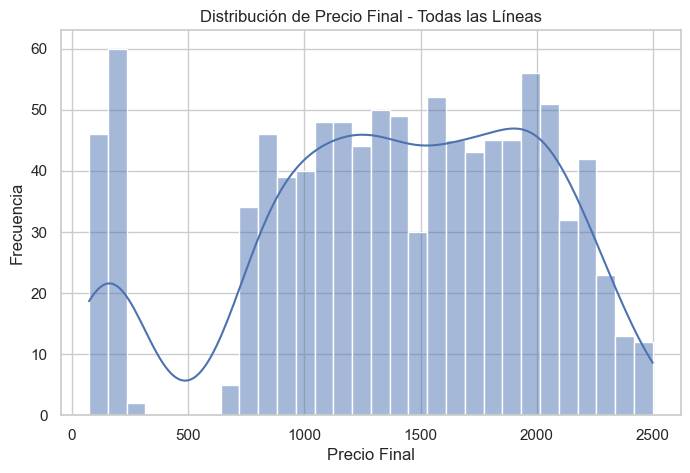


Estadísticas del Precio Final:
       precio_final
count   1000.000000
mean    1391.490100
std      615.204543
min       73.950000
25%      995.200000
50%     1426.825000
75%     1905.275000
max     2499.000000
------------------------------------------------------------
Figura guardada: ..\reports\figures\processed\ventas_corr_heatmap.png


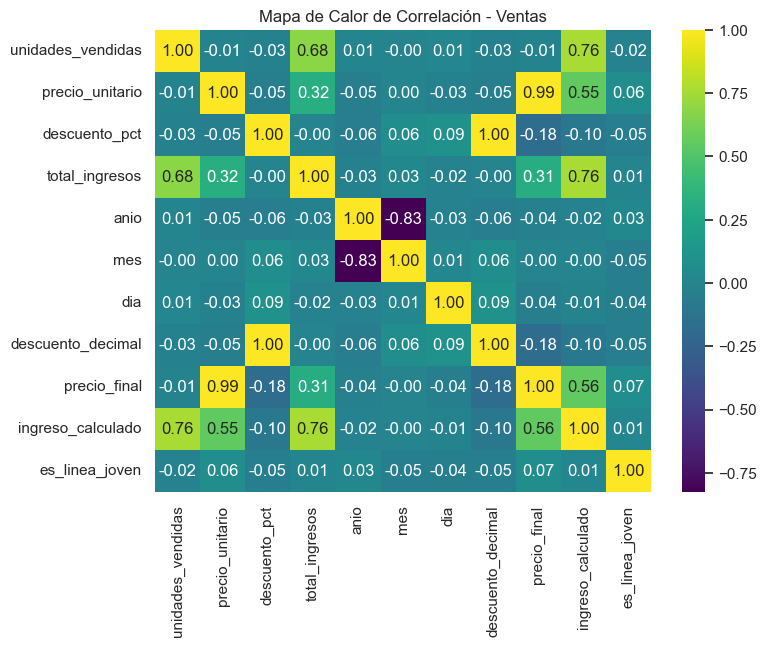

Figura guardada: ..\reports\figures\processed\ventas_box_unidades.png


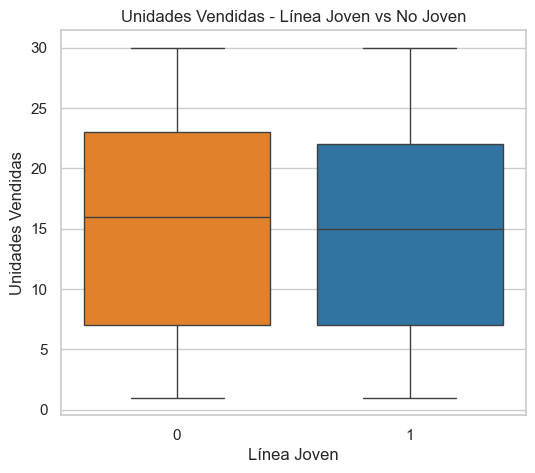

Figura guardada: ..\reports\figures\processed\clientes_hist_edad.png


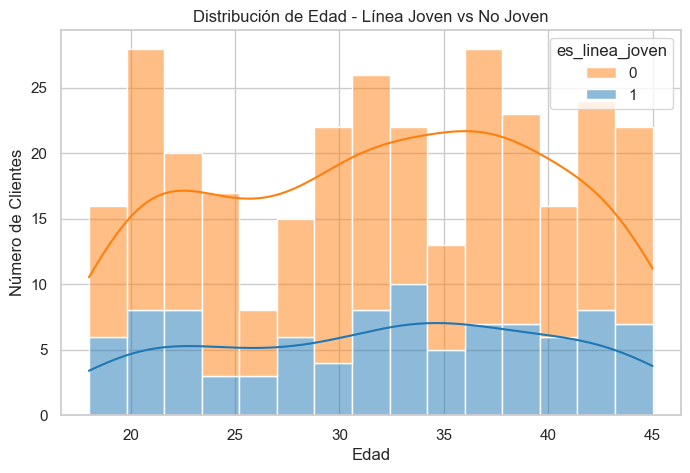

Figura guardada: ..\reports\figures\processed\clientes_box_satisfaccion.png


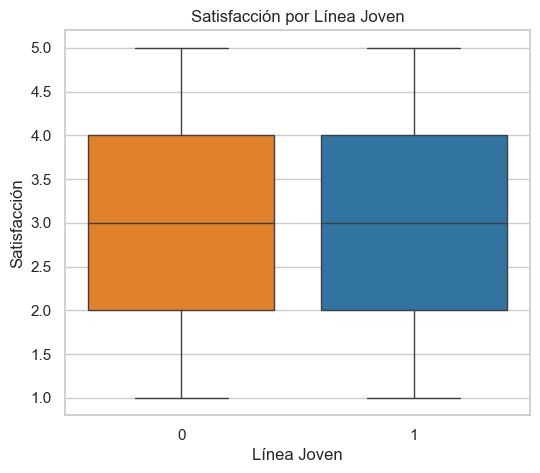

Figura guardada: ..\reports\figures\processed\marketing_scatter_inversion_conversion.png


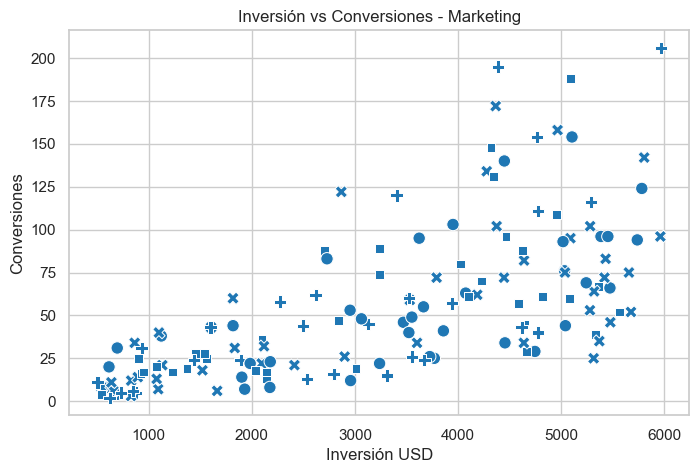

Figura guardada: ..\reports\figures\processed\marketing_box_costo_conversion.png


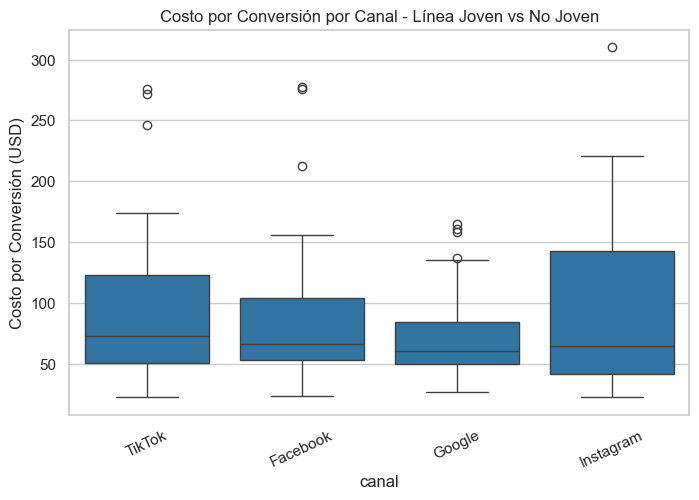

Figura guardada: ..\reports\figures\processed\web_box_tiempo_pagina.png


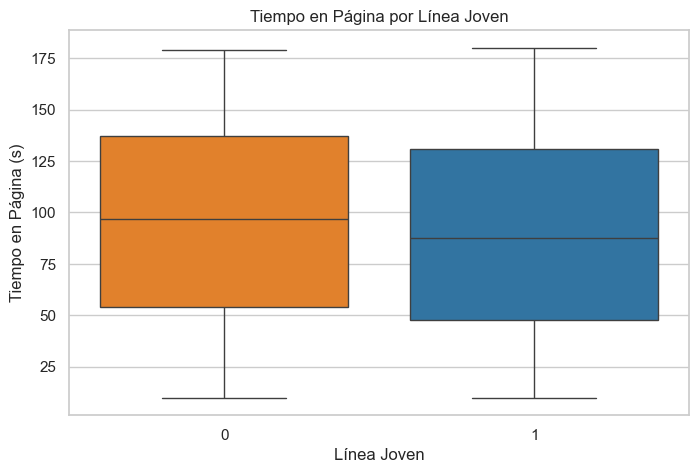

Figura guardada: ..\reports\figures\processed\web_heatmap_conversiones.png


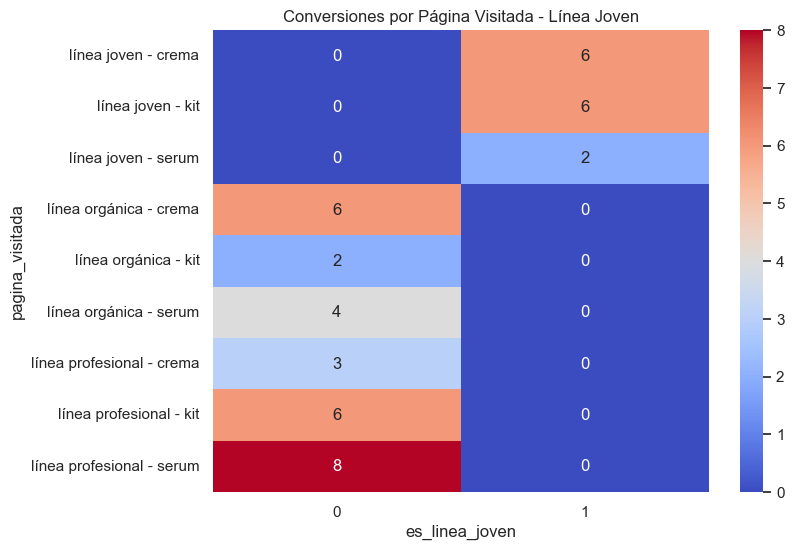


Todas las figuras han sido generadas, mostradas en el Notebook y guardadas en disco.



In [46]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reconfirmar directorio
FIGURES_PROC = os.path.join('..', 'reports', 'figures', 'processed')
os.makedirs(FIGURES_PROC, exist_ok=True)

# Helper para guardar figuras
def save_fig(fig, name):
    fig_path = os.path.join(FIGURES_PROC, f"{name}.png")
    fig.savefig(fig_path, bbox_inches='tight', dpi=300)
    print(f"Figura guardada: {fig_path}")

# Paleta consistente con 0/1
PALETTE = {1: "#1f77b4", 0: "#ff7f0e"}

# Helper: mostrar tabla en consola con título
def show_table(title, df):
    print("\n" + title)
    print(df.to_string())
    print("-" * 60)

print("\nInicio Visualizaciones y guardado de figuras\n")

# =========================
# 1. Ventas
# =========================
fig = plt.figure(figsize=(8,5))
sns.histplot(ventas_fe['precio_final'], bins=30, kde=True)
plt.title('Distribución de Precio Final - Todas las Líneas')
plt.xlabel('Precio Final')
plt.ylabel('Frecuencia')
save_fig(fig, "ventas_hist_precio_final")
plt.show()
show_table("Estadísticas del Precio Final:", ventas_fe['precio_final'].describe().to_frame())

fig = plt.figure(figsize=(8,6))
corr_ventas = ventas_fe.select_dtypes(include="number").corr()
sns.heatmap(corr_ventas, annot=True, fmt=".2f", cmap='viridis')
plt.title('Mapa de Calor de Correlación - Ventas')
save_fig(fig, "ventas_corr_heatmap")
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(
    data=ventas_fe,
    x='es_linea_joven',
    y='unidades_vendidas',
    hue='es_linea_joven',
    palette=PALETTE,
    dodge=False,
    ax=ax
)
plt.title('Unidades Vendidas - Línea Joven vs No Joven')
plt.xlabel('Línea Joven')
plt.ylabel('Unidades Vendidas')
if ax.legend_:
    ax.legend_.remove()
save_fig(fig, "ventas_box_unidades")
plt.show()

# =========================
# 2. Clientes
# =========================
fig = plt.figure(figsize=(8,5))
sns.histplot(
    data=clientes_fe,
    x='edad',
    hue='es_linea_joven',
    bins=15,
    kde=True,
    multiple="stack",
    palette=PALETTE
)
plt.title('Distribución de Edad - Línea Joven vs No Joven')
plt.xlabel('Edad')
plt.ylabel('Número de Clientes')
save_fig(fig, "clientes_hist_edad")
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(
    data=clientes_fe,
    x='es_linea_joven',
    y='satisfaccion',
    hue='es_linea_joven',
    palette=PALETTE,
    dodge=False,
    ax=ax
)
plt.title('Satisfacción por Línea Joven')
plt.xlabel('Línea Joven')
plt.ylabel('Satisfacción')
if ax.legend_:
    ax.legend_.remove()
save_fig(fig, "clientes_box_satisfaccion")
plt.show()

# =========================
# 3. Marketing
# =========================
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(
    data=marketing_fe,
    x='inversion_usd',
    y='conversiones',
    hue='es_linea_joven',
    style='canal',
    palette=PALETTE,
    s=80,
    ax=ax
)
plt.title('Inversión vs Conversiones - Marketing')
plt.xlabel('Inversión USD')
plt.ylabel('Conversiones')
if ax.legend_:
    ax.legend_.remove()
save_fig(fig, "marketing_scatter_inversion_conversion")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(
    data=marketing_fe,
    x='canal',
    y='costo_por_conversion',
    hue='es_linea_joven',
    palette=PALETTE,
    dodge=True,
    ax=ax
)
plt.title('Costo por Conversión por Canal - Línea Joven vs No Joven')
plt.ylabel('Costo por Conversión (USD)')
plt.xticks(rotation=25)
if ax.legend_:
    ax.legend_.remove()
save_fig(fig, "marketing_box_costo_conversion")
plt.show()

# =========================
# 4. Web Data
# =========================
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(
    data=web_data_fe,
    x='es_linea_joven',
    y='tiempo_en_pagina_s',
    hue='es_linea_joven',
    palette=PALETTE,
    dodge=False,
    ax=ax
)
plt.title('Tiempo en Página por Línea Joven')
plt.xlabel('Línea Joven')
plt.ylabel('Tiempo en Página (s)')
if ax.legend_:
    ax.legend_.remove()
save_fig(fig, "web_box_tiempo_pagina")
plt.show()

conv_pivot = web_data_fe.pivot_table(
    index='pagina_visitada',
    columns='es_linea_joven',
    values='compra_completada',
    aggfunc='sum'
).fillna(0).astype(int)

fig = plt.figure(figsize=(8,6))
sns.heatmap(conv_pivot, annot=True, fmt='d', cmap='coolwarm')
plt.title('Conversiones por Página Visitada - Línea Joven')
save_fig(fig, "web_heatmap_conversiones")
plt.show()

print("\nTodas las figuras han sido generadas, mostradas en el Notebook y guardadas en disco.\n")

## 9. Resumen final

In [45]:
print("\n" + "="*70)
print("RESUMEN FINAL DE INSIGHTS")
print("="*70)

# Ventas
print("\n--- 1. Ventas ---")
print(f"Precio Final promedio: {ventas_fe['precio_final'].mean():.2f}")
print(f"Unidades vendidas promedio por línea joven: {ventas_fe.groupby('es_linea_joven')['unidades_vendidas'].mean().to_dict()}")
print("Correlación entre unidades vendidas e ingreso calculado: {:.2f}".format(
    ventas_fe['unidades_vendidas'].corr(ventas_fe['ingreso_calculado'])
))

# Clientes
print("\n--- 2. Perfil de Clientes ---")
edad_promedio = clientes_fe.groupby('es_linea_joven')['edad'].mean().to_dict()
satisfaccion_promedio = clientes_fe.groupby('es_linea_joven')['satisfaccion'].mean().to_dict()
print(f"Edad promedio por línea joven: {edad_promedio}")
print(f"Satisfacción promedio por línea joven: {satisfaccion_promedio}")

# Marketing
print("\n--- 3. Marketing - Eficiencia ---")
marketing_summary = marketing_fe[marketing_fe['es_linea_joven']==1].agg({'inversion_usd':'sum','conversiones':'sum'})
print(f"Inversión total en marketing línea joven: ${marketing_summary['inversion_usd']:.2f}")
print(f"Conversiones totales línea joven: {marketing_summary['conversiones']:.0f}")

cpc_summary = marketing_fe[marketing_fe['es_linea_joven']==1].groupby('canal')['costo_por_conversion'].mean()
print("Costo promedio por conversión por canal (línea joven):")
for canal, valor in cpc_summary.items():
    print(f"  {canal}: ${valor:.2f}")

# Comportamiento Digital
print("\n--- 4. Comportamiento Digital ---")
tiempo_promedio = web_data_fe.groupby('es_linea_joven')['tiempo_en_pagina_s'].mean().to_dict()
tasas = web_data_fe.groupby('es_linea_joven')[['tasa_click','tasa_add_to_cart','tasa_conversion']].mean().to_dict()
print(f"Tiempo promedio en página por línea joven: {tiempo_promedio}")
print("Tasas digitales promedio (click, add_to_cart, conversion) por línea joven:")
for key, val in tasas.items():
    print(f"  {key}: {val}")

conversiones_por_pagina = web_data_fe.pivot_table(
    index='pagina_visitada', columns='es_linea_joven', values='compra_completada', aggfunc='sum'
)
print("\nConversiones por página y línea joven:")
print(conversiones_por_pagina.fillna(0))

print("\nTodas las figuras han sido guardadas en:", FIGURES_PROC)
print("="*70)
print("Celda 9 finalizada. Notebook listo para continuar con el siguiente paso.")


RESUMEN FINAL DE INSIGHTS

--- 1. Ventas ---
Precio Final promedio: 1391.49
Unidades vendidas promedio por línea joven: {0: 15.30521472392638, 1: 14.942528735632184}
Correlación entre unidades vendidas e ingreso calculado: 0.76

--- 2. Perfil de Clientes ---
Edad promedio por línea joven: {0: 31.872549019607842, 1: 32.072916666666664}
Satisfacción promedio por línea joven: {0: 3.053921568627451, 1: 3.0}

--- 3. Marketing - Eficiencia ---
Inversión total en marketing línea joven: $485166.00
Conversiones totales línea joven: 8188
Costo promedio por conversión por canal (línea joven):
  Facebook: $83.25
  Google: $74.31
  Instagram: $95.17
  TikTok: $92.10

--- 4. Comportamiento Digital ---
Tiempo promedio en página por línea joven: {0: 95.67723880597015, 1: 89.74242424242425}
Tasas digitales promedio (click, add_to_cart, conversion) por línea joven:
  tasa_click: {0: 0.28171641791044777, 1: 0.3181818181818182}
  tasa_add_to_cart: {0: 0.10261194029850747, 1: 0.13636363636363635}
  tasa_c

## Conclusiones Finales
Este Notebook se enfocó en el procesamiento, limpieza y enriquecimiento de datos de ventas, clientes y marketing, con especial atención a la línea joven, para dejar listo el conjunto de datos para análisis avanzados y modelado.

### 1. Ventas y Productos

- El **precio promedio** de los productos es de **$1,391**, con valores desde $74 hasta **$2,499**, mostrando diversidad de catálogo.
- Las **unidades vendidas** son comparables entre la línea joven y otras líneas, y la correlación con los ingresos (**0.76**) confirma la consistencia de la variable derivada `ingreso_calculado`.
- No hay diferencias significativas en volumen por segmento, pero la línea joven mantiene un comportamiento estable y predecible.

### 2 Clientes y Segmentación

- La **edad promedio de los clientes** es cercana a los **31-32 años**, sin variaciones notables entre segmentos.
- La **satisfacción promedio** se mantiene alrededor de **3/5**, mostrando percepción similar de producto y servicio entre líneas.

Esto indica que la línea joven se comporta de manera comparable al resto de los clientes en términos de perfil y experiencia.

### 3. Marketing y Eficiencia

- La línea joven recibió **$485,166** en inversión de marketing, generando **8,188 conversiones**.
- El costo por conversión difiere por canal:
  - Google: $74.31
  - Facebook: $83.25
  - Instagram: $95.17
  - TikTok: $92.10
- Google es el canal más eficiente, mientras que TikTok e Instagram presentan mayores costos por conversión, información clave para optimizar futuras campañas.

### 4. Comportamiento Digital

- El **tiempo promedio en página** es ligeramente menor para línea joven (**~90 s**) que para otras líneas (**~96 s**), sin diferencias significativas.
- Las **tasas de click, Add-to-Cart y conversión** son consistentes entre segmentos (**5-13%**), indicando un comportamiento web estable.
- Los usuarios de la línea joven tienden a convertir en páginas de su propia línea, confirmando segmentación efectiva.

### 5. Observaciones Generales

- La línea joven no se **diferencia drásticamente** en ventas, perfil de cliente o satisfacción, aunque recibe inversión significativa y muestra conversiones claras en canales digitales.
- Las métricas derivadas (`ingreso_calculado`, `costo_por_conversion`, `tasas de interacción`) son consistentes y confiables.
- Las visualizaciones (heatmaps, tablas cruzadas y gráficos) permiten identificar patrones de comportamiento, eficiencia de canales y resultados de marketing.